# AGH - Deep Learning in Medical Image Analysis I

Author: Marek Wodziński

Contact: wodzinski@agh.edu.pl

You are allowed to use these materials for all purposes as long as the credit is given.


# Laboratory 3 - Datasets, Dataloaders

The goal of the Laboratory 3 is to:
<ul>
  <li> Get familiar with loading images using various I/O libraries.
  <li> Implement several datasets/dataloaders in PyTorch.
  <li> Understand the parameters and limitations of PyTorch dataloaders.
</ul>

You are going to start with simple built-in datasets in torchvision to get familiar with the loading hyperparameters. Then, you will implement three datasets/dataloaders using real medical images.

### Part I - Basic Dataloaders

You are going to start with build-in dataset available in **torchvision** - a library dedicated computer vision in PyTorch. It contains several frequently used datasets for prototyping, like MNIST, CIFAR10 and others. You can check the list of available dataset under the following link:

https://pytorch.org/vision/stable/datasets.html

During this laboratory you will use the MNIST dataset.

It is recommended to read:
https://pytorch.org/tutorials/beginner/basics/data_tutorial.html before continuing.

Let's start with creating the Dataset object: 


In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import SimpleITK as sitk
import torch
import torchvision.transforms as transforms
import torchvision.transforms.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets  # Add this line for torchvision datasets
from PIL import Image
from sklearn.model_selection import train_test_split

download = True 
train = False 
root = '/content/MNIST' 
transform = transforms.ToTensor()
mnist_dataset = datasets.MNIST(root=root, train=train, download=download, transform=transform)

print(f"Testing MNIST dataset length: {len(mnist_dataset)}")


Testing MNIST dataset length: 10000


Now create the assosciated Dataloader:


In [9]:
batch_size = 16  
shuffle = False  
num_workers = 2  

mnist_dataloader = tc.utils.data.DataLoader(dataset=mnist_dataset, batch_size=batch_size, shuffle=shuffle, num_workers=num_workers)



Now, let's iterate through the dataloader and visualize the first batch.

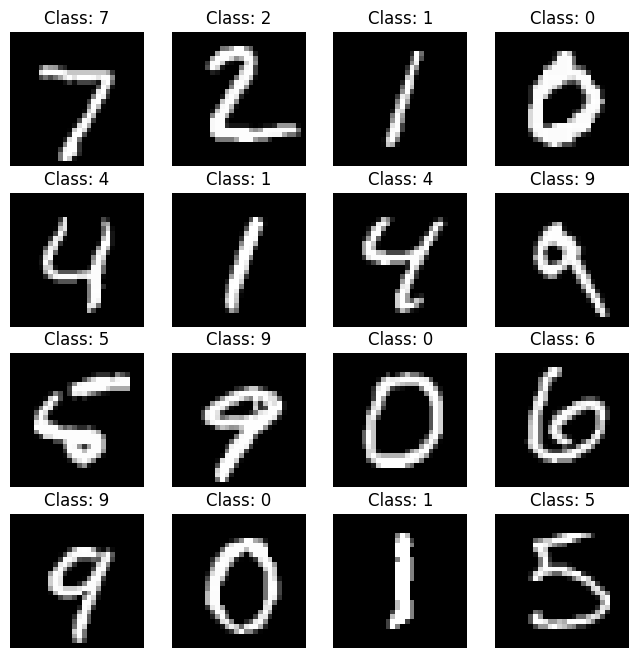

In [10]:
for images, classes in mnist_dataloader:
    
    num_images = len(images)
    fig, axs = plt.subplots(4, 4, figsize=(8, 8))

    for i in range(num_images):
        row = i // 4
        col = i % 4

        
        image = F.to_pil_image(images[i])
        
        axs[row, col].imshow(image, cmap='gray')
        axs[row, col].set_title(f'Class: {classes[i]}')
        axs[row, col].axis('off')

    plt.show()
    break  


You have used a built-in dataset and configured dataloader associated with the dataset. Next, you are going to implement several Dataset objects dedicated to medical images. 

### Part II - MRI Dataloader (simple)

In the first part of the laboratory you loaded the built-in MNIST dataset.

However, in practice, you usually have your own dataset. Independent whether the dataset is public or private, it requires a dedicated Dataset object to load the assosciated images/volumes/annotations.

To implement your own Dataset object you need to:
<ul>
  <li> Create your own class with the **tc.utils.data.Dataset** as the parent class.
  <li> Overload the **__init__** function responsible for defining the parameters assosciated with the given Dataset and initializing the logic used during loading.
  <li> Overload the **__len__** function defining the size of the Dataset (number of cases).
  <li> Overload the **__getitem__** function responsible for loading a single case within the dataset (images + additional metadata like labels or annotations).
</ul>

In the first part you are going to use the dataset containing magnetic resonance images of brain dedicated to the tumor classification.

Please download the dataset from:

https://www.kaggle.com/datasets/sartajbhuvaji/brain-tumor-classification-mri?resource=download

, and upload it to your Google Drive or directly to the Google Colaboratory **/content** folder.

If you plan to use the Google Drive (better option), you should:

On the left, under the **Files** bar, find a button called **Mount Drive** and choose your Google Drive.
It should appear in the **/content** folder as a **drive** or with different name if using non-default settings. Then you will need to unzip the dataset file to a selected path within your Google Drive.

In [11]:
input_file = None 
output_folder = None 

print(f"Input file path: {input_file}")
print(f"Output folder path: {output_folder}")



Input file path: None
Output folder path: None


Explore the unzipped data. You should see two folders inside the parent folder: **Training** and **Testing**. Inside these folders you will find four additional folders called: **pituitary_tumor**, **glioma**, **meningioma**, and **no_tumor**. All images inside these folder contain 2-D MRI slices presenting one of the classes.

Please note that the problem is simplfied - the cases are represented only by one 2-D slice from a 3-D MRI volume. In reality - the MRI imagaes are 3-D volumes containing hunderds of 2-D slices for each case.

The next task is to implement a dedicated Dataset object:

In [12]:
class BrainMRIDataset(Dataset):
    def __init__(self, dataset_path: str, mode: str = "training"):
        self.dataset_path = dataset_path
        self.mode = mode  

        if self.mode == "training":
            self.data_path = os.path.join(self.dataset_path, "Training")
        elif self.mode == "testing":
            self.data_path = os.path.join(self.dataset_path, "Testing")
        else:
            raise ValueError("Unsupported mode.")

        self.classes = os.listdir(self.data_path)  
        print(f"Available classes: {self.classes}")
        self.classes_dict = {self.classes[i]: i for i in range(len(self.classes))}
        print(f"Classes dict: {self.classes_dict}")  

        
        self.cases = []
        for class_idx, current_class in enumerate(self.classes):
            class_path = os.path.join(self.data_path, current_class)
            for current_case in os.listdir(class_path):
                case_path = os.path.join(class_path, current_case)
                self.cases.append((case_path, class_idx))

    def __len__(self):
        
        return len(self.cases)

    def __getitem__(self, idx):
        
        current_case = self.cases[idx]
        current_path, current_class = current_case
        current_image = Image.open(current_path).convert("L")  

        
        transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
        ])

        current_image = transform(current_image)

        return current_image, current_class


Now create the DataLoader responsible for loading cases from the Dataset. Notice that you do not have to make any changes with respect to the DataLoader - the interface is the same as long as the Dataset is implemented correctly.

In [13]:
dataset_path = "./lab3_data"


mri_dataset = BrainMRIDataset(dataset_path, mode="training")


batch_size = 16
shuffle = True


mri_dataloader = DataLoader(mri_dataset, batch_size=batch_size, shuffle=shuffle)


Available classes: ['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']
Classes dict: {'glioma_tumor': 0, 'meningioma_tumor': 1, 'no_tumor': 2, 'pituitary_tumor': 3}


Finally, verify whether the images are loaded correctly:

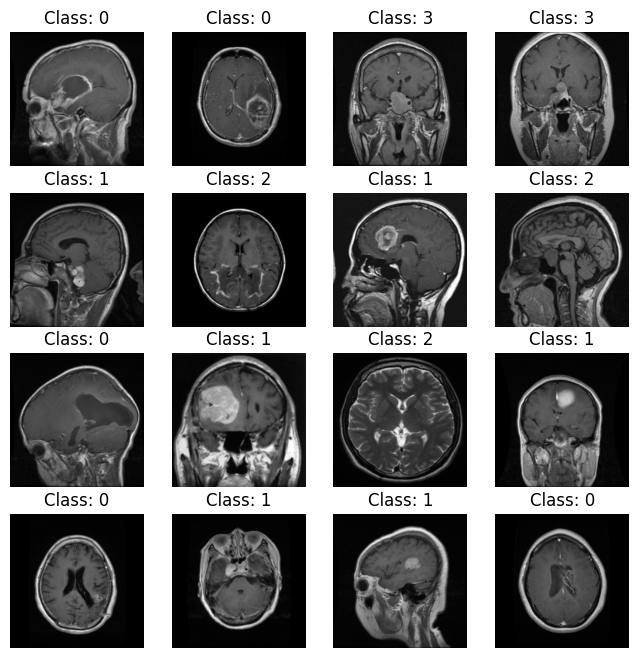

In [14]:
for images, classes in mri_dataloader:
    
    num_images = len(images)
    fig, axs = plt.subplots(4, 4, figsize=(8, 8))

    for i in range(num_images):
        row = i // 4
        col = i % 4

        
        image = F.to_pil_image(images[i])
        
        axs[row, col].imshow(image, cmap='gray')
        axs[row, col].set_title(f'Class: {classes[i]}')
        axs[row, col].axis('off')

    plt.show()
    break  


In this part you implemented a basic dataloader dedicated to MRI images. However, in practice, it is better to make the Dataset object a bit more complicated. This is the task for the next part.

### Part III - MRI Dataloader (extended)

In practice implementing the whole logic in the **__init__** function (as in the example above) is impractical. Better idea is to propose a unified representation and seperate the logic for pairing images with classes or other metadata outside the Dataset object.

The reason for this is connected with the fact that there may be more datasets than one that you would like to use at the same time and split or combine them whenever necessary. This is difficult if the datasets were acquired in different institutions without standarization.

Therefore, now slightly modify the Dataset from the previous Part by using **pandas** library to create and split the input dataset. The **csv** file should contain two columns: relative input path and the corresponding class. This way, you can firstly preprocess different datasets to the same representation and then combine them or split using just the **csv** file.

Note: In practice, for larger dataset, instead of using **csv** files you use tools dedicated to databases.

First, parse the dataset into a csv representation:

In [15]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split

# Assuming you have already created 'mri_dataset' and populated its attributes

# Create empty lists to store cases
all_cases = []

# Iterate through classes
for current_class in mri_dataset.classes:
    current_class_path = os.path.join(mri_dataset.data_path, current_class)
    
    # Iterate through cases
    for current_case in os.listdir(current_class_path):
        case_path = os.path.join(current_class_path, current_case)
        all_cases.append((case_path, mri_dataset.classes_dict[current_class], current_class))

# Convert the list of tuples to a DataFrame
all_df = pd.DataFrame(all_cases, columns=["image_path", "image_class_number", "image_class_name"])

# Split the DataFrame into training and testing sets
train_df, test_df = train_test_split(all_df, test_size=0.2, random_state=42)

# Specify paths for CSV files
training_csv_path = "./lab3_data/training.csv"
testing_csv_path = "./lab3_data/testing.csv"

# Save DataFrames to CSV files
train_df.to_csv(training_csv_path, index=False)
test_df.to_csv(testing_csv_path, index=False)

Now modify the Dataset class to use **csv** files instead of implementing the logic inside the **init** function.

In [16]:
class BrainDataset(Dataset):
    def __init__(self, dataset_path, csv_path, transforms=None, z_norm=False, target_size=(224, 224)):
        self.dataset_path = dataset_path
        self.csv_path = csv_path
        self.transforms = transforms
        self.z_norm = z_norm
        self.target_size = target_size

        
        self.dataframe = pd.read_csv(csv_path)

        if self.z_norm:
            
            self.mean = self.dataframe['image_pixels'].mean()
            self.std = self.dataframe['image_pixels'].std()

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        
        current_image_path = self.dataframe.iloc[idx]['image_path']
        current_class = self.dataframe.iloc[idx]['image_class_number']

        
        current_image = Image.open(current_image_path)

        
        current_image = current_image.resize(self.target_size, Image.ANTIALIAS)

        
        current_image = current_image.convert("L")

        if self.transforms is not None:
            current_image = self.transforms(current_image)

        
        current_image = transforms.ToTensor()(current_image)

        
        if self.z_norm:
            current_image = (current_image - self.mean) / self.std

        return current_image, current_class

And now again verify whether everything works correctly by creating the DataLoader and showing an exemplary batch from the training dataset:

C:\Users\Mateleo\AppData\Local\Temp\ipykernel_11724\1998987783.py:29: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  current_image = current_image.resize(self.target_size, Image.ANTIALIAS)


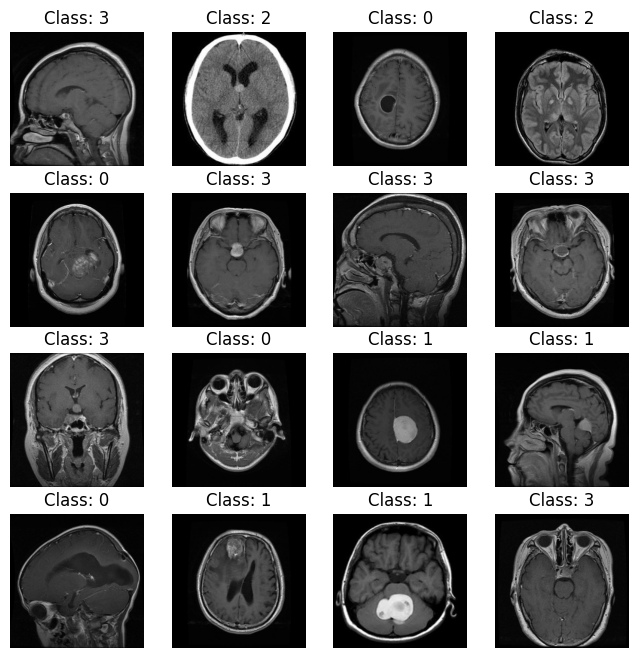

In [17]:
batch_size = 16
shuffle = True
training_dataset = BrainDataset(os.path.join(dataset_path, "training"), training_csv_path)
training_dataloader = tc.utils.data.DataLoader(training_dataset, batch_size=batch_size, shuffle=shuffle)

for images, classes in training_dataloader:
    
    num_images = len(images)
    fig, axs = plt.subplots(4, 4, figsize=(8, 8))

    for i in range(num_images):
        row = i // 4
        col = i % 4

        
        image = F.to_pil_image(images[i])
        
        axs[row, col].imshow(image, cmap='gray')
        axs[row, col].set_title(f'Class: {classes[i]}')
        axs[row, col].axis('off')

    plt.show()
    break  

You should be now familiar with implementing your own Datasets. The next part is for you to train - you are going to implement another one from scratch, without any additional guides.

### Part IV - Endoscopy Dataloader

In this part you are going to implement dataset dedicated to image segmentation (to be then used during Laboratory 6). 

The dataset is dedicated to the segmentation of surgical instruments from endoscopy images and comes from:

https://www.kaggle.com/datasets/debeshjha1/kvasirinstrument

We will use the dataset during Laboratory 6 because endoscopy images are relatively low resolution 2-D images than can be easily processed using Google Colaboratory. In reality they are video sequences, however, you are going to process just single frames.

Download the dataset and repeat the steps from the previous parts of the laboratory. Start with creating the dataset:

In [18]:
dataset_path = "./lab3_data/kvasir-instrument"


image_files = [f for f in os.listdir(os.path.join(dataset_path, "images/images")) if f.endswith(".jpg")]
mask_files = [f for f in os.listdir(os.path.join(dataset_path, "masks/masks")) if f.endswith(".png")]



data = {'image_path': [], 'mask_path': []}

for image_file in image_files:
    image_path = os.path.join("images", image_file)
    mask_file = image_file.replace(".jpg", ".png")
    mask_path = os.path.join("masks", mask_file)

    data['image_path'].append(image_path)
    data['mask_path'].append(mask_path)


df = pd.DataFrame(data)

if len(df) == 0:
    raise ValueError("Dataset is empty. Adjust dataset path or check dataset contents.")


train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)


train_csv_path = "lab3_data/kvasir-instrument/training_dataset.csv"
test_csv_path = "lab3_data/kvasir-instrument/testing_dateset.csv"

train_df.to_csv(train_csv_path, index=False)
test_df.to_csv(test_csv_path, index=False)

print(f"Training CSV saved to: {train_csv_path}")
print(f"Testing CSV saved to: {test_csv_path}")


Training CSV saved to: lab3_data/kvasir-instrument/training_dataset.csv
Testing CSV saved to: lab3_data/kvasir-instrument/testing_dateset.csv


In [19]:
class EndoscopySegmentationDataset(Dataset):
    def __init__(self, dataset_path, csv_path, transforms=None, z_norm=False, target_size=(224, 224)):
        self.dataset_path = dataset_path
        self.csv_path = csv_path
        self.transforms = transforms
        self.z_norm = z_norm
        self.target_size = target_size

        
        self.dataframe = pd.read_csv(csv_path)

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        
        img_path = os.path.join(self.dataset_path,"images", self.dataframe.iloc[idx]['image_path'])
        mask_path = os.path.join(self.dataset_path,"masks", self.dataframe.iloc[idx]['mask_path'])

        
        img = Image.open(img_path).convert("RGB")  
        mask = Image.open(mask_path).convert("L")  

        
        img = img.resize(self.target_size, Image.BILINEAR)
        mask = mask.resize(self.target_size, Image.NEAREST)

        if self.transforms is not None:
            img = self.transforms(img)
            mask = self.transforms(mask)

        img = transforms.ToTensor()(img)
        mask = transforms.ToTensor()(mask)
        
        return img, mask

C:\Users\Mateleo\AppData\Local\Temp\ipykernel_11724\2267222412.py:25: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
  img = img.resize(self.target_size, Image.BILINEAR)
C:\Users\Mateleo\AppData\Local\Temp\ipykernel_11724\2267222412.py:26: DeprecationWarning: NEAREST is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.NEAREST or Dither.NONE instead.
  mask = mask.resize(self.target_size, Image.NEAREST)


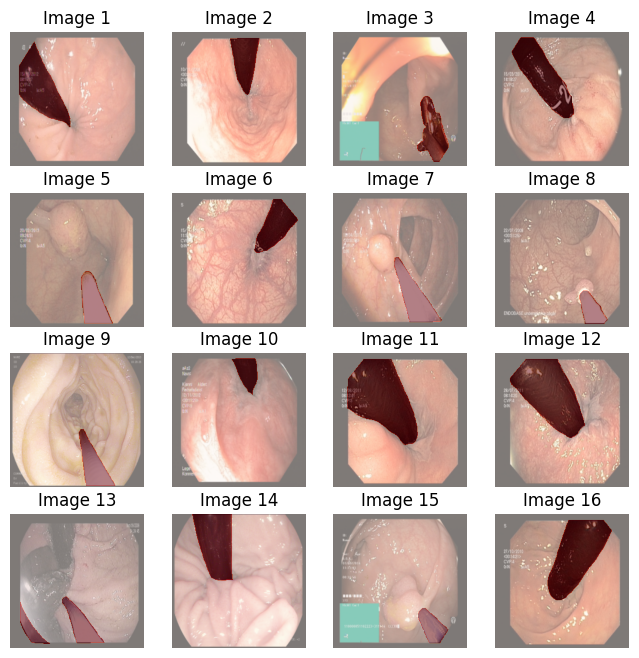

In [20]:
batch_size = 16
shuffle = True
training_dataset = EndoscopySegmentationDataset(os.path.join(dataset_path), train_csv_path)
training_dataloader = tc.utils.data.DataLoader(training_dataset, batch_size=batch_size, shuffle=shuffle)

for images, masks in training_dataloader:
    
    num_images = len(images)
    fig, axs = plt.subplots(4, 4, figsize=(8, 8))

    for i in range(num_images):
        row = i // 4
        col = i % 4

        
        image = F.to_pil_image(images[i])
        mask = F.to_pil_image(masks[i])

        axs[row, col].imshow(image)
        axs[row, col].imshow(mask, alpha=0.5, cmap='Reds')  
        axs[row, col].set_title(f'Image {i + 1}')
        axs[row, col].axis('off')

    plt.show()
    break  

### Conclusion

Congratulations, you have implemented several datasets dedicated to load medical images. You should be now able to implement you own dataset whenever necessary.

After the laboratory you should:
<ul>
  <li> Understand the difference between Dataset and Dataloader objects.
  <li> Implement your own Dataset object for a given medical dataset.
  <li> Use the Dataloader object with any Dataset to load the data using the desired hyperparameters.
  <li> Verify whether the Dataloader works and loads the data appropriately.
</ul>

During the next laboratory you are going to combine the knowledge from Laboratory 2 and Laboratory 3 to implement and train a simple convolutional neural network for medical image classification.